# PHYS20762 - Project 3 - Monte Carlo Techniques 
# Penetration of Neutrons Through Shielding

George McNie<br>
University of Manchester <br>
April 2021

The python interpreter is initialised

In [42]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
from scipy.signal import find_peaks
import scipy.constants as pc
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'font.size': 16})
plt.rcParams['text.usetex'] = True
plt.style.use('ggplot')

## Intro

Monte Carlo methods are computer algorithms that rely on repeated random sampling to obtain results. In this project this technique is used to develop a simulation of penetration through a slab of shielding with thickness T. Three materials are investigated: water, lead and graphene. Only thermal neutrons will be considered and these can either be absorbed, transmitted or reflected by the material. The simulation is also run when the neutron starts in the centre of a sphere of a certain material. Finally, the Woodcock method is implemented to determine the absorption, transmission and scattering when two of these materials are put together.

## Random number generation

### Using numpy

Python has an inbuilt random number generator, numpy.random.uniform(). Uniform randomness is such that every value in a given range has an equal probability of occurring. To confirm that this inbuilt function produces a uniform array of numbers we must test it. To do this we will look at numbers generated on a 2D plane between 1 and -1.

In [51]:
def numpy_gen(n):
    """
    generates randomly distributed numpy arrays of length n between -1 and 1

    Parameters
    ----------
    n : integer
        length of random distributed array

    Returns
    -------
    x : numpy array
        a numpy array of length n  of randomly generated numbers between -1 
        and 1
    y : numpy array
        a numpy array of length n  of randomly generated numbers between -1 
        and 1

    """
    x = np.zeros(n)
    y = np.zeros(n)
    
    for i in range(n):
        x[i] = 2 * np.random.uniform() - 1
        y[i] = 2 * np.random.uniform() - 1
    
    return (x, y)

points = [10, 100, 1000, 10000]

plt.figure(figsize=(10, 8)) #sets the figure size

for i, samples in enumerate(points):
    x, y = numpy_gen(samples)
    ax = plt.subplot(2, 2, (i+1))
    ax.scatter(x, y, color='purple')
    ax.set_title('Number of samples = {0}'.format(samples))


<IPython.core.display.Javascript object>

One can see from the plots above that the random numbers generated do not follow any pattern as such and so the numpy generator does generate random numbers. To test this more rigorously below is an average of 15 histograms for 1,000 samples generated using numpy's generator. There are 1,000 samples generated between -1 and 1 and these are catagorized into n bins. The mean value of samples in each bin should be, $$\mu = \frac{samples}{n}.$$ There is a probability, p of being in a certain bin of $$p=\frac{1}{n}.$$ All this is assuming that the samples are distributed according normally. Therefore the error on the mean is $$ \sigma =  \sqrt{samples * p}.$$

In [54]:
bins = 20
samples = 10000
num_histos = 15 #number of histograms found
p= 1/bins
expected_mean = samples/bins
expected_error = np.sqrt(samples * p) 

cumulitive_histos = np.zeros((num_histos, bins))

for i in range(num_histos):  
    x, _ = numpy_gen(samples)
    hist, bin_edges = np.histogram(x, bins)
    cumulitive_histos[i, :] = hist

mean_x = np.mean(cumulitive_histos, axis = 0)
std_freq = np.std(cumulitive_histos, axis = 0)


#plotting histogram
plt.figure(figsize=(10, 8))
#plt.hist(mean_x, bins, edgecolor='k')
plt.hist(bin_edges[:-1], bin_edges, weights=mean_x, edgecolor='purple')
plt.axhline(expected_mean , linestyle = 'dashed', color = 'k')
plt.axhline(expected_mean + (expected_error/2), linestyle = 'dashdot', color = 'green') #SORT OUT ERRORS
plt.axhline(expected_mean - (expected_error/2), linestyle = 'dashdot', color = 'green')
plt.ylabel('Number in range', fontsize=16)
plt.xlabel('Range', fontsize=16)
plt.show()

<IPython.core.display.Javascript object>

One can see from the histogram above that all values fall within the range of acceptable bands (indicated by green lines), confirming that the numpy function gives random numbers. The black line is the mean value expected.

### 3D and the spectral problem

The Linear Congruential Generator (LCG) is a pseudo-random number generator - produces a sequence of numbers that exhibit statistical randomness. The sequence is entirely deterministic, and so the next number is determined by the previous one. With a given seed, this carries on until you reach a number that's already occurred, and a loop of the same numbers is created. Invented by Lehmer, the LCG works as follows:
$$ X_{n+1} = (aX_n + c) \;\; mod \; m .$$
The parameters must adhere to:
- The modulus, m: $0<m$
- The multiplier, a: $0 \leq a < m$
- The increment, c: $0<c<m$
- The seed, $X_0$: $0 \leq X_0 <m$

The LCG repeats over a full period m if all parameters are fulfilled. However, the parameters a and m must be chosen carefully as you can get numbers that generate patterns and get correlation between points. This is known as Masaglia's theorem, and is prominent in the RANDU (type of LCG) algorithm:
$$V_{j+1} = (65539V_j) \;\; mod \;2^{31}.$$


<IPython.core.display.Javascript object>


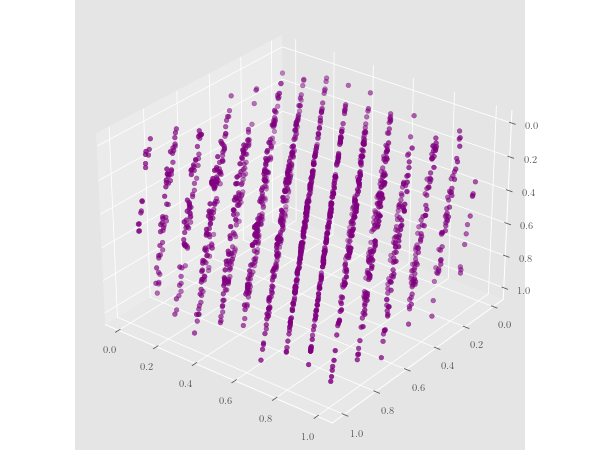

In [55]:
def randu(p,q):
    """
    generates random numbers using an LCG, generates a p by q matrix

    Parameters
    ----------
    p : integer
        number of dimensions want to get random numbers for
    q : integer
        number of coordinate points

    Returns
    -------
    r : array
        p by q matrix of pseudo random points

    """   
    try: x
    except NameError:
        m = pow(2, 31)
        a = pow(2, 16) + 3
        c = 0
        x = 123456789
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    
    return r

randu_arr = randu(3, 1500)

get_ipython().magic('matplotlib notebook')
#using instead of %matplotlib inline for rotation

fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)
ax.scatter(randu_arr[0, :], randu_arr[1, :], randu_arr[2, :], color='purple')
ax.view_init(-151, -128)


In the plot above the RANDU algorithm is plotted. Here hyperplanes are clearly seen thus there is correlation between these so called "random" points. Obviously, this is not a good random number generator, as there is correlation every 3 points. To observe these planes is known as the spectral test.

Therefore, we need a way that doesn't rely on the LCG to generate random points in 3D space. To do this the numpy random uniform number generator explored before is used.


<IPython.core.display.Javascript object>


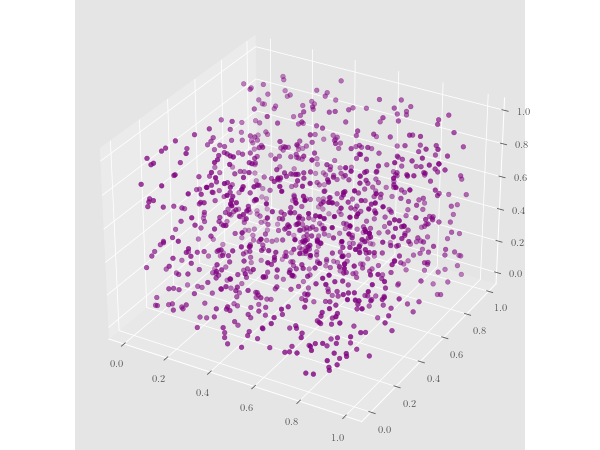

In [56]:
x = np.random.uniform(size = 1000)
y = np.random.uniform(size = 1000)
z = np.random.uniform(size = 1000)
    
fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)
ax.scatter(x, y, z, color='purple')

One can see in the graph above that with the numpy generator there are no hyperplanes when rotating about an axis. Thus the spectral problem does not exist with this generator.


### Exponential Distribution

One can use the fact that the spectral problem doesn't occur with this generator to implement it in a random number generator distributed according to an exponential function. This is done by finding the inverse cumulative distribution. The probability distribution function is given as:
$$pdf(x) = e^{-x / \lambda},$$
and so the cumulative distribution is,
$$z = cdf(x) = \int_{0}^{x}pdf(x) = \lambda(1-e^{-x / \lambda}).$$
This means the inverse cdf is
$$cdf^{-1}(x) = -\lambda ln(1-\frac{z}{\lambda})$$ 
from here the random variable x can be generated,
$$x_i = -\lambda ln(1-u_{i})$$
where $u_i$ is a uniform random variable. We can say $1-u_i$ is just $u_i$ as it's just another random variable resulting in the generation of random variables according to the exponential distribution as,
$$x_i = -{\lambda}ln(u_i).$$


In [57]:
def exponential_generator(lambd):
    """
    An exponential generator. Once initialised will return a value of random x
    that is distributed according to an exponential function

    Parameters
    ----------
    lambd : float
        is a constant of the generator but will be used as the mean free path
        when utilised

    Yields
    ------
    x : float
        random number distributed accordig to exponential function

    """
    while True:
        x = (-lambd)*np.log(np.random.uniform())
        yield x
        

## Particle Transport

### Absorption

If a particle is traversing through a material, it can get absorbed. The number of absorbing particles is
$$n= \frac{\rho N_A}{M},$$
where $\rho$ is the density of the material, $M$ is the molar mass. The number of neutrons absorbed in a thin layer:
$$N_L = n \sigma IL$$
where $\sigma$ is the microscopic absorption cross-section and $I$ is the neutron intensity. The Rate of absorption per unit thickness,
$$R= -\frac{\mathrm{d} I}{\mathrm{d} x}= n\sigma I,$$
and so the intensity variation with thickness is,
$$I(x) = I_0e^{-n \sigma x} = e^{-x/ \lambda},$$
where $\lambda$ is the mean free path and I_0 is the original intensity.
The formula uses the fact that $$\lambda = \frac{1}{\Sigma} = \frac{1}{n \sigma}$$
is used above. $\Sigma$ is the macroscopic cross-section.

This means that the probability of an arbitrary particle in a material travelling a distance x in a material with mean free path $\lambda$ before being absorbed by the material is
$$P(x) = e^{-n/\lambda}.$$
Because of this we can use the exponential distribution function from before.


In [58]:
def get_mfp(density, mass, crosssec):
    """
    calculates the mean free path in a material according to parameters

    Parameters
    ----------
    density : float
        density of material
    mass : float
        molar mass of material
    crosssec : float
        cross section of material

    Returns
    -------
    the mean free path of materials

    """
    return(mass / (crosssec * density * pc.Avogadro))

There is a difference between the mean free path of an ensemble of particles using exponentially distributed functions and that of the calculated nominal value (as given by the formula above). 

To see this, below a histogram is plotted of the distance many neutrons have travelled through water before they are absorbed.  Water has $\sigma_{absorption} = 0.6652$ barn, $M= 18.01528$ mol and $\rho = 1.00 \; g/cm^3$. As with all nuclear experiments the units are in cgs.

To simulate the distance travelled before absorption, a given number of neutrons are distributed according to the exponential formula above. This simulation is run many times to give an average and error for the distance categories of each bin in the histogram. One can calculate the error on each bin's mean by doing the standard deviation on each bin.


In [59]:
bins = 30
samples = 1000
num_histos = 50 #number of histograms found (simulations run)
water_nominal_mfp = get_mfp(1, 18.01528, 6.652e-25) 

<IPython.core.display.Javascript object>


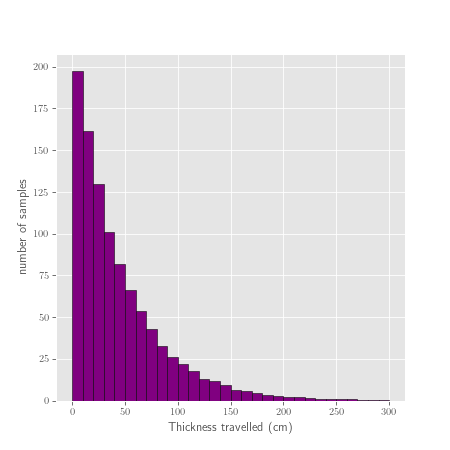

In [60]:
cumulitive_histos = np.zeros((num_histos, bins))
bin_points = np.arange(0, 300 + 0.1, (300/bins))

for i in range(num_histos):      
    exg = exponential_generator(water_nominal_mfp) #initialises the generator
    water_dist = [next(exg) for i in range(samples)] #gets random variables exponentially distributed
    hist, bin_edges = np.histogram(water_dist, bins = bin_points) #sets max value in histogram to be 300 just from eyeballing
    cumulitive_histos[i, :] = hist

mean_freq = np.mean(cumulitive_histos, axis = 0)
std_freq = np.std(cumulitive_histos, axis = 0)


#plotting histogram
plt.figure(figsize=(6, 6))
plt.hist(bin_edges[:-1], bin_edges, weights=mean_freq, edgecolor='k', color='purple')
plt.xlabel('Thickness travelled (cm)')
plt.ylabel('number of samples')
plt.show()

One can calculate the value of the mean free path from this cumulation of distributions of path length. When $ln(samples)$ is plotted against the length travelled a straight line is acquired. This line has a $$gradient = \frac{-1}{\lambda}$$ and so the mean free path through is able to be calculated from an ensemble of neutrons.

Basic error propagation is done to produce the graph on the rights errors. As the natural log of the value have been taken, the propagation of error is given as $$\frac{1}{x} \sigma_x$$
where $x$ is the value from each bin and $\sigma_x$ is the error on this value. The line of best fit is also plotted with a weighting according to this error so that values with higher values are less proportionally represented by the line. This means that the value of $\lambda$ (calculated using the line) is more accurate.


<IPython.core.display.Javascript object>


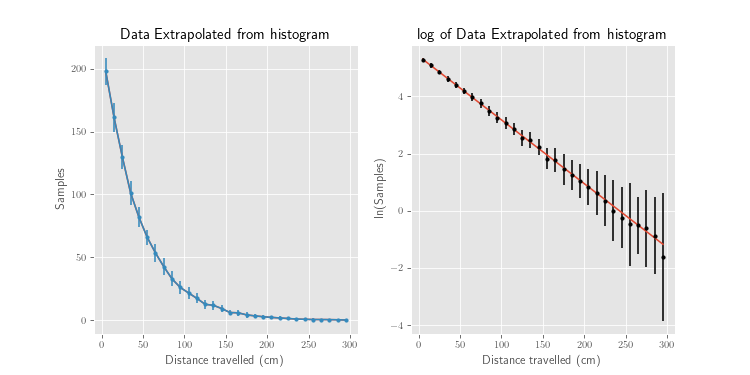

The mean free path found is 44.804, +/- 0.210, the nominal value is 44.972


In [61]:
#need as have 1 too many bins, gets midpoints of bins
mid_bins = np.zeros(len(bin_edges)-1)
for i, _ in enumerate(mid_bins):
    mid_bins[i] = bin_edges[i] + (bin_edges[(i+1)] - bin_edges[i])/2

#removes zeros from all arrays
filtered_std = np.delete(std_freq, np.argwhere(mean_freq == 0))
filtered_bins = np.delete(mid_bins, np.argwhere(mean_freq == 0))
filtered_mean = np.delete(mean_freq, np.argwhere(mean_freq == 0))


ln_mean = np.log(filtered_mean)
propogated_std = (1/filtered_mean) * filtered_std


parameters, errors = np.polyfit(filtered_bins, ln_mean, 1, cov=True, w=(1/propogated_std))
gradient = parameters[0]
error_gradient = np.sqrt(errors[0][0])
y_intercept = parameters[1]
line = gradient * filtered_bins + y_intercept
mfp_found = -1/ gradient
mfp_error = error_gradient / gradient**2

plt.figure(figsize=(10, 5)) #sets the figure size

ax_1 = plt.subplot(1, 2, 1)
ax_1.plot(filtered_bins, filtered_mean)
ax_1.errorbar(filtered_bins, filtered_mean, yerr=filtered_std, marker = '.')
ax_1.set_ylabel('Samples')
ax_1.set_xlabel('Distance travelled (cm)')
ax_1.set_title('Data Extrapolated from histogram')

ax_2 = plt.subplot(1, 2, 2)
ax_2.errorbar(filtered_bins, ln_mean, yerr=propogated_std, marker = '.', color = 'k', ls='none')
ax_2.plot(filtered_bins, line)
ax_2.set_ylabel('ln(Samples)')
ax_2.set_xlabel('Distance travelled (cm)')
ax_2.set_title('log of Data Extrapolated from histogram')

print("The mean free path found is {0:.3f}, +/- {1:.3f}, the nominal value is {2:.3f}".format(mfp_found, mfp_error, 
                                                                                              water_nominal_mfp))


The graph on the right shows how the distance travelled by neutrons is distributed exponentially using a random number generator. The larger errors on the data as the distance increases is explained by the histogram in the previous figure. As there are less neutrons in these bins, the proportional error is much larger than those at lower distances.

One can also see that there is a fluctuation between the nominal mean free path and that calculated by the ensemble produced using the random number generator. The calculated values' error however falls within the nominal value thus one can conclude that the random path generator is correct.

However, as the number of simulations approaches infinity these two values should become identical. One can see this beginning to converge in the plot below.


In [62]:
import time

def vary_sims(simulations, nominal_mfp, num_bin, sample):
    """
    Function to calculate the mean free path given a certain amount of 
    simulations. The time to calculate this is documented.

    Parameters
    ----------
    simulations : integer
        number of simulations to be run
    nominal_mfp : float
        the calculated mean free path
    num_bin : integer
        the number of bins that data is sorted into
    sample : integer
        number of neutrons in each simulation

    Returns
    -------
    mfp_found: float
        the mean free path calculated in the function
    mfp_error: float
        the error on the calculated mfp
    time_taken: float
        time taken for the mean free path to be calculated

    """
    start = time.time()
    cumulitive_histos = np.zeros((simulations, num_bin))
    bin_points = np.arange(0, 300 + 0.1, (300/num_bin))

    water_dist = (-nominal_mfp)*np.log(np.random.uniform(size=sample))
    
    for i in range(simulations):      
        water_dist = (-nominal_mfp)*np.log(np.random.uniform(size=sample)) #done like this to improve efficiency 
        hist, bin_edges = np.histogram(water_dist, bins = bin_points) #sets max value in histogram to be 300 just from eyeballing
        cumulitive_histos[i, :] = hist

    mean_freq = np.mean(cumulitive_histos, axis = 0)
    std_freq = np.std(cumulitive_histos, axis = 0)
    
    #need as have 1 too many bins, gets midpoints of bins
    mid_bins = np.zeros(len(bin_edges)-1)
    for i, _ in enumerate(mid_bins):
        mid_bins[i] = bin_edges[i] + (bin_edges[(i+1)] - bin_edges[i])/2

    #removes zeros from all arrays
    filtered_std = np.delete(std_freq, np.argwhere(mean_freq == 0))
    filtered_bins = np.delete(mid_bins, np.argwhere(mean_freq == 0))
    filtered_mean = np.delete(mean_freq, np.argwhere(mean_freq == 0))


    ln_mean = np.log(filtered_mean)
    propogated_std = (1/filtered_mean) * filtered_std

    parameters, errors = np.polyfit(filtered_bins, ln_mean, 1, cov=True, w=(1/propogated_std))
    gradient = parameters[0]
    error_gradient = np.sqrt(errors[0][0])
    mfp_found = -1/ gradient
    mfp_error = error_gradient / gradient**2
    end = time.time()
    time_taken = end-start

    return(mfp_found, mfp_error, time_taken)

<IPython.core.display.Javascript object>


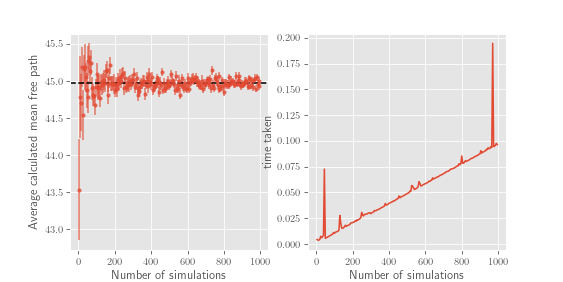

Text(0, 0.5, 'time taken')

In [80]:
water_nominal_mfp = get_mfp(1, 18.01528, 6.652e-25)
bins = 30
samples = 1000
sims = np.arange(5,1000, step=5)
to_inf = np.zeros((len(sims), 3))
for j, value in enumerate(sims):
    to_inf[j, 0], to_inf[j, 1], to_inf[j, 2] = vary_sims(value, water_nominal_mfp, bins, samples)

plt.figure(figsize=(10, 5))

ax_1 = plt.subplot(1,2,1)
ax_1.errorbar(sims, to_inf[:,0], yerr = to_inf[:,1], marker='.', ls='none', alpha=0.7)
ax_1.axhline(water_nominal_mfp, color='k', ls='dashed')
ax_1.set_xlabel('Number of simulations')
ax_1.set_ylabel('Average calculated mean free path')

ax_2 = plt.subplot(1,2,2)
ax_2.plot(sims, to_inf[:,2])
ax_2.set_xlabel('Number of simulations')
ax_2.set_ylabel('time taken')

The left-hand graph shows that as the number of simulations run goes to infinity the mean free path of the ensemble gets closer to the value of the nominal mean free path, as expected. However, there are always outliers even when the number of simulations is significantly greater. This could be caused by one particle being an extremely large outlier, and so to improve this code those should be removed. At simulations lower than 400 there are too many outliers to consider running less than 400 simulations. 

The right-hand plot shows that in general run time increases linearly with the number of simulations run. There are more fluctuations in run time at values of simulations lower than 500. These fluctuations are most probably due to the fact there are greater proportional errors and so these run times are exaggerated.

Overall, the optimal number of simulations to run would be around 500, as it accurately comes close to the nominal value for the mean free path without having an incredibly large run time.


### Scattering

When a particle is travelling through a medium it can not only get absorbed but also scattered. In our model the particle can be scattered in every direction with equal probability. Therefore, a program must be created to find a random direction in 3D space. To find these isotropic vectors (use unit vector) is seen as follows:

<IPython.core.display.Javascript object>


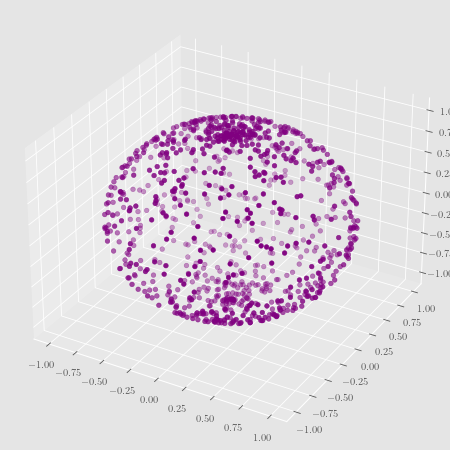

In [81]:
def iso_unit_wrong():
    """
    generator that tries to generate an isotropic unit vector, but is wrong

    Yields
    ------
    x : float
        x coordinate
    y : float
        y coordinate
    z : float
        z coordinate

    """
    while True:
        theta = np.pi * np.random.uniform()
        phi = 2 * np.pi * np.random.uniform()
        x = np.sin(theta) * np.cos(phi)
        y= np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        yield (x, y, z)

        
points = 1000        
        
x = np.zeros(points)
y = np.zeros(points)
z = np.zeros(points)

w_iso = iso_unit_wrong() #initialises the generator
for i in range(1000):
    x_gen, y_gen, z_gen = next(w_iso)
    x[i] = x_gen
    y[i] = y_gen
    z[i] = z_gen

fig = plt.figure(figsize = (6,6))
ax = Axes3D(fig)
ax.scatter(x, y, z, color='purple')

As seen in the plot above there is a strong pattern of points locating themselves around the poles. To solve this and get a uniformly distributed isotropic vectors one must define the function and say that
$$\theta_i = acos(1-2u_i).$$

<IPython.core.display.Javascript object>


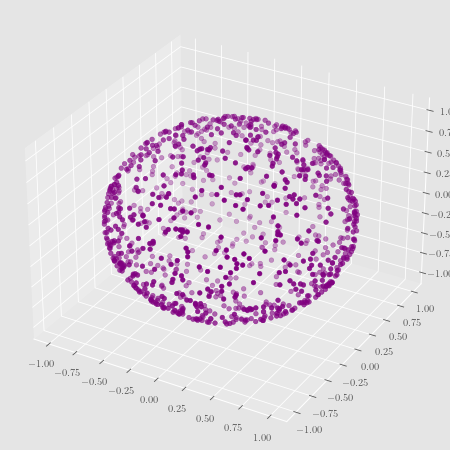

In [82]:
def iso_unit():
    """
    generator that generates an isotropic unit vector
    fixes the problem in previous function
    
    Yields
    ------
    x : float
        x coordinate
    y : float
        y coordinate
    z : float
        z coordinate

    """
    while True:
        theta = np.arccos(1 - 2*np.random.uniform())
        phi = 2 * np.pi * np.random.uniform()
        x = np.sin(theta) * np.cos(phi)
        y= np.sin(theta) * np.sin(phi)
        z = np.cos(theta)
        yield (x, y, z)
     
        
x = np.zeros(points)
y = np.zeros(points)
z = np.zeros(points)

iso = iso_unit() #initialises the generator
for i in range(points):
    x_gen, y_gen, z_gen = next(iso)
    x[i] = x_gen
    y[i] = y_gen
    z[i] = z_gen
    
fig = plt.figure(figsize = (6,6))
ax = Axes3D(fig)
ax.scatter(x, y, z, color='purple')

The points generated are isotropic unit vectors, and so it can be used for our scattering purposes.

Combining this with a generator for the distance travelled by a particle, one gets an isotropic step generator. Below is the code that generates isotropic steps with lengths distributed as $e^{-x/\lambda}$.


<IPython.core.display.Javascript object>


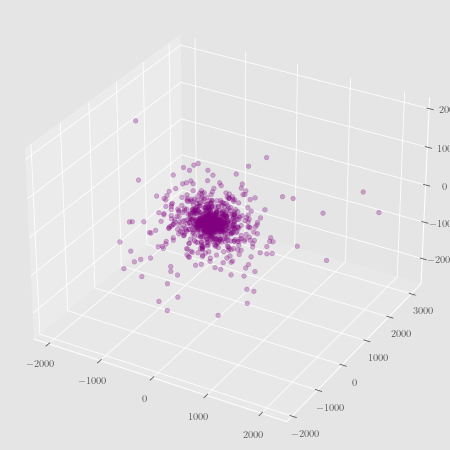

In [83]:
def iso_step(n, density, m, sigma):
    """
    function that generate n an isotropic steps

    Yields
    ------
    x : array
        x coordinates
    y : array
        y coordinates
    z : array
        z coordinates

    """
    exg = exponential_generator(get_mfp( density, m, sigma)) #initialises the path distance generator
    iso = iso_unit() #initialises the direction generator
    x = []
    y = []
    z = []
    
    for i in range(n):
        x_gen, y_gen, z_gen = next(iso)
        r = next(exg)
        x.append(x_gen * r)
        y.append(y_gen * r)
        z.append(z_gen * r)
    return(x, y, z)

x, y, z = iso_step(1000, 1, 18.01528, 0.6652e-25)

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.scatter(x, y, z, color='purple', alpha = 0.3)

The plot above visualises what many different isotropic steps that are exponentially distributed look like.

### Multiple Process'

Both of these process' occur but what occurs when? Each process has a different effect on the neutron and so we have a $\sigma_a$ microscopic cross-section for absorption and $\sigma_s$ microscopic cross-section for scattering. This gives us a mean free path,
$$\lambda = \frac{1}{\Sigma_T} = \frac{1}{n(\sigma_a + \sigma_s)}.$$
The probability of absorption is
$$P_a=\frac{\Sigma_a}{\Sigma_T} = \frac{\sigma_a}{\sigma_a + \sigma_s}$$
and the probability of scattering is
$$P_s=\frac{\Sigma_s}{\Sigma_T} = \frac{\sigma_s}{\sigma_a + \sigma_s}.$$

## Thermal neutrons travelling in sheet of material

Here the travel of thermal neutrons through 3 different materials, water, lead and graphite is investigated. Each neutron starts from one surface of the slab (at $x = 0$) and performs a random walk where each step is drawn from the exponential distribution. When the neutron hits a molecule, it will either be scattered or absorbed. To decide this, a random number is generated between 0 and 1, if this number is less than the probability of absorption then the particle is absorbed. If it is more the particle is scattered. 

First each material's properties are defined:

In [84]:
# columns are water, lead, graphite
material = np.array([['Water', 'Lead', 'Graphite'], #0
                    [0.6652e-24, 0.158e-24, 0.0045e-24], #absorption cross sec (cm^2) 1
                    [103.0e-24, 11.221e-24, 4.74e-24],  #scattering cross sec (cm^2) 2
                    [1.00, 11.35, 1.67], # density (g/cm^3) 3
                    [18.01528, 207.2, 12.01], # mass per mol 4
                    [0, 0, 0], # to calc resultant mfp 5
                    [0, 0, 0], # to calc probability of absorption 6
                    [0,0,0]], dtype = object) # to calc probability of scattering 7

#resultant mfp calculated
for i, _ in enumerate(material[0]):
    mfp_absorp = get_mfp(material[3,i], material[4,i], material[1, i])
    mfp_scatter = get_mfp(material[3,i], material[4,i], material[2, i])
    combine_mfp = get_mfp(material[3,i], material[4,i], (material[1, i] + material[2, i])) 
    material[5,i] = combine_mfp
    material[6,i] = (1/mfp_absorp) * combine_mfp
    material[7,i] = (1/mfp_scatter) * combine_mfp
    

As each neutron starts at $x=0$, and can only move forwards a separate function for the first step must be written, to ensure the neutron enters the material in purely the x direction. 

In [85]:
def first_step(material_ind):
    """
    function to perform the first step in code

    Parameters
    ----------
    material_ind : integer
        corresponds to column in greater material array of material examining

    Returns
    -------
    x : integer
        x coordinate   
    y : integer
        y coordinate
    z : integer
        z coordinate
    """
    exg = exponential_generator(material[5, material_ind]) #initialises the path distance generator
    r = next(exg)
    x = r
    y = 0
    z = 0

    return(x, y, z)

The function for the later isotropic steps has to be adapted, to take into account the new material array holding all of the information for each material.

In [86]:
def iso_step_gen(material_ind):
    """
    generator version of other isotropic step function.
    generates an isoptropic exponentially distributed vector

    Parameters
    ----------
    material_ind : integer
        corresponds to column in greater material array of material examining

    Returns
    -------
    x : integer
        x coordinate   
    y : integer
        y coordinate
    z : integer
        z coordinate
    """
    exg = exponential_generator(material[5, material_ind]) #initialises the path distance generator
    iso = iso_unit() #initialises the direction generator
    while True:    
        x_gen, y_gen, z_gen = next(iso)
        r = next(exg)
        x = x_gen * r
        y = y_gen * r
        z = z_gen * r
        yield(x, y, z)

Now a function can be written to generate random paths that one can visualise. This function is not optimized and as such doesn't run extremely fast due to the fact np.vstack and many if/else statements are used. This does not matter too much though as this function doesn't get called many times and thus the run time of the program isn't badly affected.

In [87]:
def path_gen(material_ind, thickness, store_coords):
    """
    Function to generate the path of a single neutron through a given material

    Parameters
    ----------
    material_ind : integer
        corresponds to column in greater material array of material examining
    thickness : float
        thickness of material examining
    store_coords : bool
        if want to store the coordinates of the path

    Returns
    -------
    coord : array
        path of the neutron if store_coords is True
        doesn't have siginicant meaning otherwise
    count : integer
        amount of times the neutron interacts with the material
    is_absorbed : integer
        1 if neutron absorbed, 0 otherwise
    left_slab : integer
        1 if neutron transmitted, 0 otherwise
    is_reflected : integer
        1 if neutron reflected, 0 otherwise

    """
    is_absorbed = 0
    left_slab = 0
    is_reflected = 0

    step_gen = iso_step_gen(material_ind) #initialises the isotropic step generator
    coord = np.zeros((1,3)) #creates an array to add coordinates to
    count = 0

    while is_absorbed == 0 and left_slab == 0 and is_reflected == 0:
        if count == 0: #first step
            moves = first_step(material_ind)
            coord = np.vstack((coord, moves))
            sum_coords = np.array(moves)

        else: #if not first step
            #gets x from previous step
            x = sum_coords[0]

            #generates new step
            rand_number = np.random.uniform()
            moves1 = next(step_gen)
            sum_coords += moves1


            if x > thickness: #checks if transmitted
                left_slab = 1
            elif x < 0: #checks if reflected back
                is_reflected = 1
            elif rand_number < material[6, material_ind]: #gets absorbed
                is_absorbed = 1
            else:
                if store_coords == True:
                    coord = np.vstack((coord,sum_coords))

        count+=1

    return(coord, count, is_absorbed, left_slab, is_reflected)

Here paths of absorption, transmission and reflection are plotted for each material. One can see how the neutrons travel. The dots are each point at which they have an interaction with the material. Each material is 5cm.

<IPython.core.display.Javascript object>


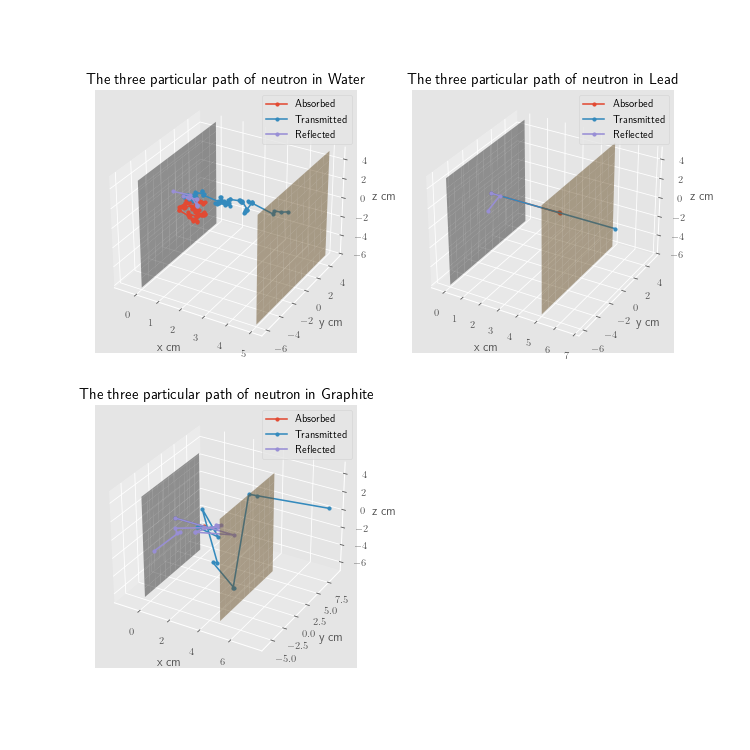

In [88]:
plt.figure(figsize=(10, 10))
thick = 5

for j, name in enumerate(material[0]):
    is_absorbed = 0
    is_transmit = 0
    is_reflected = 0

    while is_absorbed == 0 or is_transmit == 0 or is_reflected == 0:
        coords, _, absorbed, transmit, reflected = path_gen(j, thick, True)
        if absorbed != 0:
            is_absorbed = 1
            absorbed_coord = coords
        elif transmit != 0:
            is_transmit = 1
            transmit_coord = coords
        elif reflected != 0:
            is_reflected = 1
            reflected_coord = coords
    
    if j == 0:
        num = 1
    elif j == 1:
        num = 2
    elif j == 2:
        num = 3
    
    Y, Z = np.meshgrid(np.arange(-6, 6), np.arange(-6, 6))
    X_1 = 0*Y
    X_2 = 5+ X_1
    
    ax = plt.subplot(2, 2, (num), projection='3d')
    ax.plot(absorbed_coord[:,0], absorbed_coord[:,1], absorbed_coord[:,2], label='Absorbed', marker='.')
    ax.plot(transmit_coord[:,0], transmit_coord[:,1], transmit_coord[:,2], label='Transmitted', marker='.')
    ax.plot(reflected_coord[:,0], reflected_coord[:,1], reflected_coord[:,2], label='Reflected', marker='.')
    ax.legend()
    ax.plot_surface(X_1, Y, Z, alpha=0.5)
    ax.plot_surface(X_2, Y, Z, alpha=0.5)
    ax.set_ylabel('y cm')
    ax.set_xlabel('x cm')
    ax.set_zlabel('z cm')
    ax.set_title('The three particular path of neutron in ' + name)


One can see that a particular path in water will take a lot more steps than that in the other materials as water has a overall $\lambda = 0.288$ whereas lead has $\lambda = 2.664$ and graphite $\lambda = 2.517$.

The functions above have been rewritten as before they required a lot of computational power using generator functions to do the same job as the new functions below. The new functions run much faster as they utilise numpy arrays, which work with compiled code and are optimised for speed by being vectorized.

The function to decide the movement of neutrons takes the steps of all neutrons at once and also decides which ones are reflected, absorbed or transmitted all in one step, meaning very fast run times. This is used to find the proportion of neutrons reflected, absorbed or transmitted in each material.


In [89]:
def new_exponential(lambd, n):
    """
    generates a numpy array of length n of exponentially distributed numbers

    Parameters
    ----------
    lambd : float
        nominal mean free path
    n : integer
        size of array to be generated

    Returns
    -------
    x : numpy array
        values of exponentially distributed numbers
    """
    x = (-lambd)*np.log(np.random.uniform(size = n))
    return(x)
    
def new_iso_unit(n):
    """
    generates a numpy array of, length n, of isotropic unit vectors

    Parameters
    ----------
    n : integer
        size of array to be generated

    Returns
    -------
    x : numpy array
        x coordinate of isotropic unit vector
    y : numpy array
        y coordinate of isotropic unit vector
    z : numpy array
        z coordinate of isotropic unit vector

    """
    theta = np.arccos(1 - 2*np.random.uniform(size=n))
    phi = 2 * np.pi * np.random.uniform(size=n)
    x = np.sin(theta) * np.cos(phi)
    y= np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return(x, y, z)

def new_iso_step(material_ind, n):
    """
    generates a numpy array of isoptropic exponentially distributed vectors of
    size n

    Parameters
    ----------
    material_ind : integer
        corresponds to column in greater material array of material examining
    n : integer
        size of array to be generated

    Returns
    -------
    step : numpy array
        an array of tuples of isotropic exponentially distributed vectors, 
        (x,y,z) 

    """
    r = new_exponential(material[5,material_ind], n)
    iso_unit = new_iso_unit(n)     
    step = r * iso_unit
    return(step)

def new_first_step(material_ind, n):
    """
    generates the first step of n neutrons

    Parameters
    ----------
    material_ind : integer
        corresponds to column in greater material array of material examining
    n : integer
        size of array to be generated

    Returns
    -------
    x : numpy array
        x coordinates   
    y : numpy array
        y coordinates
    z : numpy array
        z coordinates

    """
    r = new_exponential(material[5,material_ind], n)
    x = r
    y=  0
    z = 0
    return(x, y, z)

def movement(material_ind, thickness, iterations, neutrons):
    """
    simulates the movement of n neutrons through a material simultaneously,
    giving the amount reflected, absorbed and scattered.

    Parameters
    ----------
    material_ind : integer
        corresponds to column in greater material array of material examining
    thickness : float
        thickness of material simulated
    iterations : integer
        number of simulations to be done
    neutrons : integer
        number of neutrons to be simulated

    Returns
    -------
    mean : numpy array
        mean number of electrons reflected, absorbed, transmitted after all
        simulations
    error : numpy array
        error on mean of electrons reflected, absorbed, transmitted after all
        simulations

    """
    RAT = np.zeros((iterations, 3))
    for i in range(iterations):
        reflection = 0
        transmission = 0
        absorption = 0
        
        #FIRST STEP
        total_move, _, _ = new_first_step(material_ind, neutrons) #just in x
        u = np.random.uniform(size=len(total_move))
        reflection += len(np.argwhere(total_move<0))
        transmission += len(np.argwhere(total_move > thickness))
        absorption += len(np.argwhere((total_move>0) & (total_move<thickness) & (u < material[6, material_ind])))
        total_move = np.delete(total_move, np.argwhere((total_move<0) | (total_move > thickness) |
                                                           (u < material[6, material_ind])))
        
        #MOVES AFTER FIRST STEP
        while len(total_move) > 0:
            new_move, _, _ = new_iso_step(material_ind, len(total_move))
            total_move += new_move
            u = np.random.uniform(size=len(total_move))
            reflection += len(np.argwhere(total_move<0))
            transmission += len(np.argwhere(total_move > thickness))
            absorption += len(np.argwhere((total_move>0) & (total_move<thickness) & (u < material[6, material_ind])))
            total_move = np.delete(total_move, np.argwhere((total_move<0) | (total_move > thickness) |
                                                           (u < material[6, material_ind])))
        
        RAT[i, 0] = reflection
        RAT[i, 1] = absorption
        RAT[i, 2] = transmission 
        
    mean = np.mean(RAT, axis = 0)
    error = np.std(RAT, axis = 0)
    
    return (mean, error)

Using these optimised functions, the proportion of reflection, absorption and transmission is calculated for each material of thickness $=10cm$. 

<IPython.core.display.Javascript object>


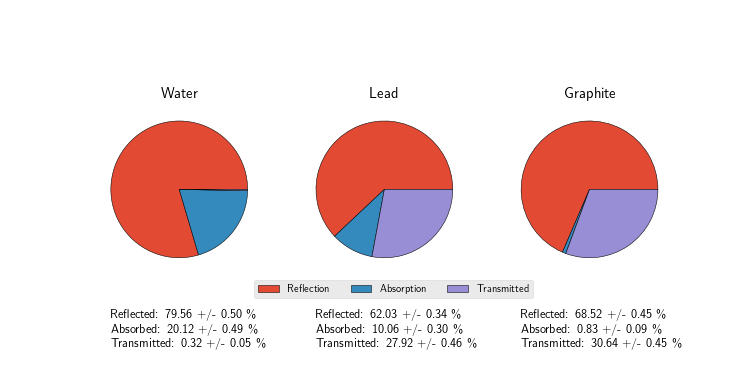

In [90]:
my_labels = ['Reflection', 'Absorption', 'Transmitted']                        
neutrons = 10000
iterations = 15
plt.figure(figsize=(10, 5)) #sets the figure size

w, w_err = movement(0, 10, iterations, neutrons)
l, l_err = movement(1, 10, iterations, neutrons)
g, g_err = movement(2, 10, iterations, neutrons)

per_w = (w/neutrons) * 100
per_w_err = (w_err/neutrons) * 100
per_l = (l/neutrons) * 100
per_l_err = (l_err/neutrons) * 100
per_g = (g/neutrons) * 100
per_g_err = (g_err/neutrons) * 100


text_1 = """Reflected: {0:.2f} +/- {1:.2f} \%
Absorbed: {2:.2f} +/- {3:.2f} \% 
Transmitted: {4:.2f} +/- {5:.2f} \% \n""".format(per_w[0], per_w_err[0], per_w[1], per_w_err[1], per_w[2], per_w_err[2])
                                                                                            
                                                                                                      
text_2 = """Reflected: {0:.2f} +/- {1:.2f} \%
Absorbed: {2:.2f} +/- {3:.2f} \% 
Transmitted: {4:.2f} +/- {5:.2f} \% \n""".format(per_l[0], per_l_err[0], per_l[1], per_l_err[1], per_l[2], per_l_err[2])
       
                                                 
text_3 = """Reflected: {0:.2f} +/- {1:.2f} \%
Absorbed: {2:.2f} +/- {3:.2f} \% 
Transmitted: {4:.2f} +/- {5:.2f} \% \n""".format(per_g[0], per_g_err[0], per_g[1], per_g_err[1], per_g[2], per_g_err[2])

ax_1 = plt.subplot(1, 3, 1)
ax_1.set_title('Water')
ax_1.pie(w, wedgeprops = {'edgecolor' : 'k'})
ax_1.text(0.1, -0.5, text_1, fontsize = 12, transform=ax_1.transAxes)

ax_2 = plt.subplot(1, 3, 2)
ax_2.set_title('Lead')
ax_2.pie(l, wedgeprops = {'edgecolor' : 'k'})
ax_2.text(1.3, -0.5, text_2, fontsize = 12, transform=ax_1.transAxes)

ax_3 = plt.subplot(1, 3, 3)
ax_3.set_title('Graphite')
patches, _ = ax_3.pie(g, wedgeprops = {'edgecolor' : 'k'})
ax_3.text(2.5, -0.5, text_3, fontsize = 12, transform=ax_1.transAxes)

plt.legend(patches, my_labels, bbox_to_anchor =(0.2, 0), ncol = 3)


The figure above shows the proportion of what happens to each neutron in every material. 

Water's proportions can be explained by it having a very high probability of scattering. This along with the fact that it's total combined mean free path (absorption and scattering taken into account) is very low, means that many interactions happen near the surface of water. This results in many neutrons being reflected.

Lead has the lowest probability of absorption, and highest probability of scattering which is why it's value for percentage of neutrons scattered is so low. However, the absorption rate isn't as high as water even though the probability of absorption is two times greater. This is as the mean free path of lead is ~10 times greater than water, so there are less interactions with lead molecules than with water molecules. This helps to explain why the transmission rate is high for lead.

Graphite's high transmission can be put down to the same explanation. There is a very low probability of absorption in graphite also as it's absorption cross section is very small.

### Varying thickness of single material

By varying the thickness of the material, we can observe the mean free path of neutrons in the material compared to the nominal value (as in absorption section). This is done by observing how transmission of neutrons vary with thickness. The graph of $ln(transmitted)$ against thickness' gradient gives a straight line, the gradient of this is the characteristic attenuation length.

In [91]:
def vary_thick(thick_arr, thicknesses, material_ind, neutrons, iterations):
    """
    a function to calculate the absorption, transmission and reflection rates
    for a varying thickness

    Parameters
    ----------
    thick_arr : numpy array
        the different thickness' for RAT to be calculated for
    thicknesses : int
        number of thicknesses in thick_arr.
    material_ind : int
        corresponds to column in greater material array of material examining
    neutrons : int
        number of neutrons to be simulated

    Returns
    -------
    t_rate : numpy array
        transmission rates for each thickness
    t_error : numpy array
        transmission rate errors for each thickness
    a_rate : numpy array
        absorption rates for each thickness 
    a_error : numpy array
        absorption rate errors for each thickness
    r_rate : numpy array
        reflection rates for each thickness    
    r_error : numpy array
        reflection rates error for each thickness
    mfp_found : numpy array
        the mean free path calculated for each material
    mfp_error : numpy array
        the error on mean free path calculated for each material

    """
    RAT = np.zeros((thicknesses, 3))
    RAT_err = np.zeros((thicknesses, 3))
    for i, thickness in enumerate(thick_arr):
        RAT[i,:], RAT_err[i,:] = movement(material_ind, thickness, iterations, neutrons)
    
        
    scaled = (RAT/neutrons) * 100
    scaled_err = (RAT_err/RAT) * scaled
    
    
    t_rate = scaled[:,2]
    t_error = scaled_err[:,2]
    t_error_prop = (1/t_rate) * t_error
    
    a_rate = scaled[:,1]
    a_error = scaled_err[:,1]
    
    r_rate = scaled[:,0]
    r_error = scaled_err[:,0]
    
    
    #removes zeros from all arrays
    amend_transmission_rate = np.delete(t_rate, np.argwhere((t_rate == 0) | (t_error_prop == 0)))
    amend_error = np.delete(t_error, np.argwhere((t_rate == 0) | (t_error_prop == 0)))
    amend_error_prop = np.delete(t_error_prop, np.argwhere((t_rate == 0) | (t_error_prop == 0)))
    
    parameters, errors = np.polyfit(thick_arr, np.log(amend_transmission_rate), 1, cov=True, w=(1/amend_error_prop))
    gradient = parameters[0]
    error_gradient = np.sqrt(errors[0][0])
    atten_found = -1/ gradient
    atten_error = error_gradient / gradient**2
       
    return(t_rate, t_error, a_rate, a_error, r_rate, r_error, atten_found, atten_error)


<IPython.core.display.Javascript object>


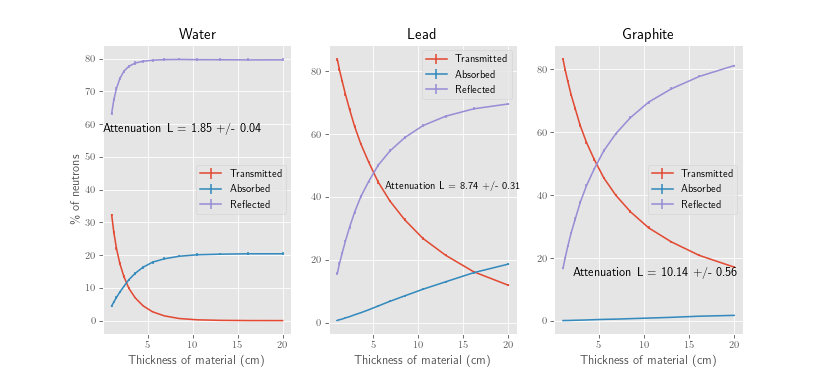

In [92]:
thicknesses = 15
thickness_arr = np.geomspace(1, 20, thicknesses)
neutrons = 10000
iterations = 15

w_trans, w_t_error, w_absorb, w_a_error, w_reflect, w_r_error, w_att, w_att_e = vary_thick(thickness_arr, 
                                                                                          thicknesses, 0, neutrons, iterations)
l_trans, l_t_error, l_absorb, l_a_error, l_reflect, l_r_error, l_att, l_att_e = vary_thick(thickness_arr, 
                                                                                         thicknesses, 1, neutrons, iterations)
g_trans, g_t_error, g_absorb, g_a_error, g_reflect, g_r_error, g_att, g_att_e = vary_thick(thickness_arr, 
                                                                                           thicknesses, 2, neutrons, iterations)

text_4 = "Attenuation L = {0:.2f} +/- {1:.2f}".format(w_att, w_att_e)
text_5 = "Attenuation L = {0:.2f} +/- {1:.2f}".format(l_att, l_att_e)
text_6 = "Attenuation L = {0:.2f} +/- {1:.2f}".format(g_att, g_att_e)

plt.figure(figsize=(11, 5)) #sets the figure size

ax_1 = plt.subplot(1, 3, 1)
ax_1.errorbar(thickness_arr, w_trans, yerr=w_t_error, label='Transmitted')
ax_1.errorbar(thickness_arr, w_absorb, yerr=w_a_error, label='Absorbed')
ax_1.errorbar(thickness_arr, w_reflect, yerr=w_r_error, label='Reflected')
ax_1.set_xlabel('Thickness of material (cm)')
ax_1.set_ylabel('\% of neutrons')
ax_1.set_title('Water')
ax_1.text(0, 0.7, text_4, fontsize = 12, transform=ax_1.transAxes)
ax_1.legend()

ax_2 = plt.subplot(1, 3, 2)
ax_2.errorbar(thickness_arr, l_trans, yerr=l_t_error, label='Transmitted')
ax_2.errorbar(thickness_arr, l_absorb, yerr=l_a_error, label='Absorbed')
ax_2.errorbar(thickness_arr, l_reflect, yerr=l_r_error, label='Reflected')
ax_2.set_xlabel('Thickness of material (cm)')
ax_2.set_title('Lead')
ax_2.text(0.3, 0.5,text_5, fontsize = 10, transform=ax_2.transAxes)
ax_2.legend()

ax_3 = plt.subplot(1, 3, 3)
ax_3.errorbar(thickness_arr, g_trans, yerr=g_t_error, label='Transmitted')
ax_3.errorbar(thickness_arr, g_absorb, yerr=g_a_error, label='Absorbed')
ax_3.errorbar(thickness_arr, g_reflect, yerr=g_r_error, label='Reflected')
ax_3.set_xlabel('Thickness of material (cm)')
ax_3.set_title('Graphite')
ax_3.text(0.1, 0.2, text_6, fontsize = 12, transform=ax_3.transAxes) 
ax_3.legend()



The characteristic attenuation length is the distance where the intensity of the beam of neutrons has dropped by $1/e$.

For water one can see that the values of each process reach a constant value after the thickness of the material has been changed very little. The transmitted function appears to vary exponentially, which is expected. The characteristic attenuation is smallest for water is the smallest, this means for a given amount of material it will transmit neutrons the least.

For lead all the values of each process' proportions vary with thickness' and by 20cm have not reached their final values. The increasing proportion of reflection as thickness increases is due to the fact more interactions can occur as thickness increases. Due to the large mean free path in lead, when the length of material is small it won't have many interactions giving a high transmission rate and low absorption and reflection. As the thickness increases though the transmission decreases due to more interactions and thus gives more absorption and reflection.

For graphite we see a similar behaviour as with lead, but with a very low absorption due to the probability of absorption being ~1000 times less likely than the probability of scattering. This means it has a higher charecteristic attenuation length than lead.

The error bars on the plot are there but are very small.


## Thermal neutron travelling in a sphere

Instead of a slab a neutron travelling through a sphere is simulated. This could be useful if a source of neutrons is not wanted and so a sphere around it is needed to contain them. The neutron will start at the centre of the sphere and so it can only be either absorbed by or transmitted out of the material.

In [93]:
def path_gen_sphere(material_ind, radius, store_coords):
    """
    function to generate the path of a neutron in a sphere of material

    Parameters
    ----------
    material_ind : int
        corresponds to column in greater material array of material examining
    radius : float
        radius of sphere used
    store_coords : bool
        to store coordinates of points if true

    Returns
    -------
    coord : numpy array
        path of the neutron if store_coords is True
        doesn't have siginicant meaning otherwise
    count : integer
        amount of times the neutron interacts with the material
    is_absorbed : integer
        1 if neutron absorbed, 0 otherwise
    left_slab : integer
        1 if neutron transmitted, 0 otherwise
    """
    is_absorbed = 0
    left_slab = 0

    step_gen = iso_step_gen(material_ind) #initialises the isotropic step generator
    coord = np.zeros((1,3)) #creates an array to add coordinates to
    sum_coords = np.zeros(3)
    count = 0

    while is_absorbed == 0 and left_slab == 0:
        #gets x from previous step
        r = np.sqrt(sum_coords[0]**2 + sum_coords[1]**2 + sum_coords[2]**2)
        
        #generates new step
        rand_number = np.random.uniform()
        moves1 = next(step_gen)
        sum_coords += moves1

        if r > radius: #checks if transmitted
            left_slab = 1
        elif rand_number < material[6, material_ind]: #gets absorbed
            is_absorbed = 1
        else:
            if store_coords == True:
                coord = np.vstack((coord,sum_coords))

        count+=1

    return(coord, count, is_absorbed, left_slab)

<IPython.core.display.Javascript object>


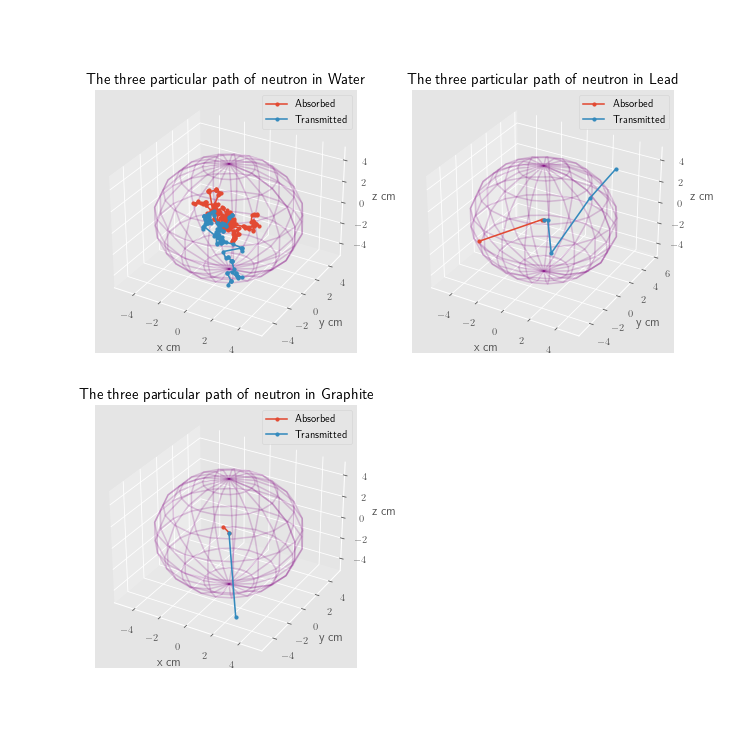

In [94]:
radius = 5
plt.figure(figsize=(10, 10))

for j, name in enumerate(material[0]):
    is_absorbed = 0
    is_left = 0

    while is_absorbed == 0 or is_left == 0:
        coords, _, absorbed, out = path_gen_sphere(j, radius, True)
        if absorbed != 0:
            is_absorbed = 1
            absorbed_coord = coords
        elif out != 0:
            is_left = 1
            left_coord = coords

    if j == 0:
        num = 1
    elif j == 1:
        num = 2
    elif j == 2:
        num = 3

    
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    X = radius * np.cos(u)*np.sin(v)
    Y = radius * np.sin(u)*np.sin(v)
    Z = radius * np.cos(v)
    
    ax = plt.subplot(2, 2, (num), projection='3d')
    ax.plot(absorbed_coord[:,0], absorbed_coord[:,1], absorbed_coord[:,2], label='Absorbed', marker='.')
    ax.plot(left_coord[:,0], left_coord[:,1], left_coord[:,2], label='Transmitted', marker='.')
    ax.legend()
    ax.plot_wireframe(X, Y, Z, alpha=0.2, color='purple')
    ax.set_ylabel('y cm')
    ax.set_xlabel('x cm')
    ax.set_zlabel('z cm')
    ax.set_title('The three particular path of neutron in ' + name)



In [95]:
def movement_sphere(material_ind, radius, iterations, neutrons):
    """
    simulates the movement of n neutrons through a sphere of material 
    simultaneously, giving the amount absorbed and scattered.

    Parameters
    ----------
    material_ind : integer
        corresponds to column in greater material array of material examining
    radius : float
        radius of sphere of material
    iterations : integer
        number of simulations to be done
    neutrons : integer
        number of neutrons to be simulated
    Returns
    -------
    mean : numpy array
        mean number of electrons absorbed, transmitted after all simulations
    error : numpy array
        error on mean of electrons absorbed, transmitted after all simulations

    """
    AT = np.zeros((iterations, 2))
    for i in range(iterations):
        absorption = 0
        left = 0
        
        #CHECK THIS
        x_gen, y_gen, z_gen = new_first_step(material_ind, neutrons) #just in x
        total_r = np.sqrt(x_gen**2 + y_gen**2 + z_gen**2)
        u = np.random.uniform(size=len(total_r))
        left += len(np.argwhere(total_r > radius))
        absorption += len(np.argwhere((total_r < radius) & (u < material[6, material_ind])))
        total_r = np.delete(total_r, np.argwhere((total_r > radius) | (u < material[6, material_ind])))
        
        while len(total_r) > 0:
            new_x, new_y, new_z = new_iso_step(material_ind, len(total_r))
            new_r = np.sqrt(new_x**2 + new_y**2 + new_z**2)
            total_r += new_r
            u = np.random.uniform(size=len(total_r))
            left += len(np.argwhere(total_r > radius))
            absorption += len(np.argwhere((total_r < radius) & (u < material[6, material_ind])))
            total_r = np.delete(total_r, np.argwhere((total_r > radius) | (u < material[6, material_ind])))
                        
       
        AT[i, 0] = absorption
        AT[i, 1] = left
                
    mean = np.mean(AT, axis = 0)
    error = np.std(AT, axis = 0)
    
    return (mean, error)

<IPython.core.display.Javascript object>


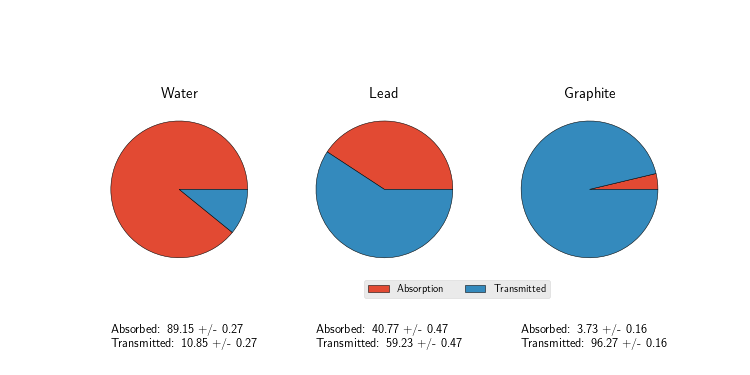

In [96]:
my_labels = ['Absorption', 'Transmitted']                        
neutrons = 10000
iteration = 5
plt.figure(figsize=(10, 5)) #sets the figure size

water_s, water_s_err = movement_sphere(0, 100, iteration, neutrons)
lead_s, lead_s_err = movement_sphere(1, 100, iteration, neutrons)
graphite_s, graphite_s_err = movement_sphere(2, 100, iteration, neutrons)

per_s_w = (water_s/neutrons) * 100
per_s_w_err = (water_s_err/neutrons) * 100
per_s_l = (lead_s/neutrons) * 100
per_s_l_err = (lead_s_err/neutrons) * 100
per_s_g = (graphite_s/neutrons) * 100
per_s_g_err = (graphite_s_err/neutrons) * 100

text_1 = """Absorbed: {0:.2f} +/- {1:.2f} % 
Transmitted: {2:.2f} +/- {3:.2f} % \n""".format(per_s_w[0], per_s_w_err[0], per_s_w[1], per_s_w_err[1])

text_2 = """Absorbed: {0:.2f} +/- {1:.2f} % 
Transmitted: {2:.2f} +/- {3:.2f} % \n""".format(per_s_l[0], per_s_l_err[0], per_s_l[1], per_s_l_err[1])
                                                                                        
text_3 = """Absorbed: {0:.2f} +/- {1:.2f} % 
Transmitted: {2:.2f} +/- {3:.2f} % \n""".format(per_s_g[0], per_s_g_err[0], per_s_g[1], per_s_g_err[1])

ax_1 = plt.subplot(1, 3, 1)
ax_1.set_title('Water')
ax_1.pie(water_s, wedgeprops = {'edgecolor' : 'k'})
ax_1.text(0.1, -0.5, text_1, fontsize = 12, transform=ax_1.transAxes)

ax_2 = plt.subplot(1, 3, 2)
ax_2.set_title('Lead')
ax_2.pie(lead_s, wedgeprops = {'edgecolor' : 'k'})
ax_2.text(1.3, -0.5, text_2, fontsize = 12, transform=ax_1.transAxes)

ax_3 = plt.subplot(1, 3, 3)
ax_3.set_title('Graphite')
patches, _ = ax_3.pie(graphite_s, wedgeprops = {'edgecolor' : 'k'})
ax_3.text(2.5, -0.5, text_3, fontsize = 12, transform=ax_1.transAxes)

plt.legend(patches, my_labels, bbox_to_anchor =(0.3, 0), ncol = 3)

One can see that water is clearly the best at containing neutrons being emitted by a source, so a sphere of this should be used to contain neutrons.

## Thermal neutron travelling through 2 materials (Woodcock method)

The Woodcock method allows for neutrons to travel through 2 different materials at once. If Woodcock methods were not utilised then as a neutron passed over the boundary of two materials, it's path length would be wrong in the other material.

To overcome this in the Wookcock method one takes fictitious steps according to the material that has the shortest mean free path and takes fictitious steps according to that path. This means that in the longer mean free path region, the steps taken
too short. To compensate for this the probability of a fictitious step is
$$p[f] = \frac{\sum _{majorant} - \sum _1}{\sum _{majorant}}$$
where $\sum _1$ is the first material's $\sum$. This simulation works on the fact that the first material is not the majorant material.

In [97]:
def w_first_step(mfp):
    """
    generates first step in woodcock method. needed to recreate as must take 
    mean free path argument of majorant material

    Parameters
    ----------
    mfp : float
        mean free path of majorant material

    Returns
    -------
    x : float
        x coordinates   
    y : float
        y coordinates
    z : float
        z coordinates

    """
    exg = exponential_generator(mfp) #initialises the path distance generator
    r = next(exg)
    x = r
    y = 0
    z = 0

    return(x, y, z)

def normal_step(sum_coord, coord_f, thickness, sig_T, material_ind):
    """
    takes a non ficticious step in either material

    Parameters
    ----------
    sum_coord : Tfloat
        the current x coordinate of neutron
    coord_f : numpy array
        all previous coordinates of neutron
    thickness : float
        thickness of both materials
    sig_T : float
        sigma of majorant material
    material_ind : int
        index of material in corresponding to material array

    Returns
    -------
    sum_coord : float
        the current x coordinate of neutron
    coord_f : numpy array
        all previous coordinates of neutron
    direc_f : tuple
        coordinates that the previous moves direction was made in        
    t : int
        1 if transmitted, 0 otherwise
    re : int 
        1 if reflected, 0 otherwise
    a : int
        1 if absorbed, 0 otherwise
    """    
    
    t = 0
    re = 0
    a = 0

    exg = exponential_generator((1/sig_T)) #initialises the path distance generator
    iso = iso_unit() #initialises isotropic unit generator

    x = sum_coord[0]

    #generates new step
    rand_number = np.random.uniform()

    r = next(exg)
    direc_f = next(iso)
    x_gen, y_gen, z_gen = direc_f
    x_fict = x_gen * r
    y_fict = y_gen * r
    z_fict = z_gen * r
    moves1 = (x_fict,y_fict,z_fict)
    sum_coord += moves1

    if x > thickness: #checks if transmitted
        t = 1
    elif x < 0: #checks if reflected back
        re = 1
    elif rand_number < material[6, material_ind]: #gets absorbed
        a = 1
    else:
         coord_f = np.vstack((coord_f,sum_coord))

    return(sum_coord, coord_f, direc_f, t, re, a)

The methods below are not optimal. 

In [98]:
def woodcock_path(material_ind_1, material_ind_2, thickness_1, thickness_2):
    """
    gets the path of a neutron travelling through a combination of two 
    materials using woodcock method.

    Parameters
    ----------
    material_ind_1 : int
        index of 1st material corresponding to material array
    material_ind_2 : int
        index of  2nd material corresponding to material array
    thickness_1 : float
        thickness of first material
    thickness_2 : float
        thickness of second material

    Returns
    -------
    coord : numpy array
        coordinates of path of neutron
    is_absorbed : int
        1 if absorbed, 0 otherwise
    left_slab : int
        1 if transmitted, 0 otherwise
    is_reflected : int
        1 if reflected, 0 otherwise

    """
    is_absorbed = 0
    left_slab = 0
    is_reflected = 0
    thickness = thickness_1 + thickness_2
    
    if material_ind_1 == 3:
        sig_1 = 0
    else:
        sig_1 = 1/material[5, material_ind_1]
    sig_2 = 1/material[5, material_ind_2]
    sig_T = np.amax([sig_1, sig_2])

    coord = np.zeros((1,3)) #creates an array to add coordinates to
    count = 0

    exg = exponential_generator((1/sig_T)) #initialises the path distance generator

    direc = (1,0,0) #sets initial direction

    while is_absorbed == 0 and left_slab == 0 and is_reflected == 0:
        if count == 0: #first step
            moves = w_first_step((1/sig_T))
            coord = np.vstack((coord, moves))
            sum_coords = np.array(moves)

        else: #if not first step

            x = sum_coords[0] #gets x from previous step
            fict_rand_num = np.random.uniform() #generates random variable for ficticious step

            #if last_fict == 0:
            #    direc = next(iso)
            if x < thickness_1 and x>0:
                if fict_rand_num > (sig_1/sig_T): #take fict step
                    x_gen, y_gen, z_gen = direc #keeps previous direction
                    r = next(exg)
                    x_fict = x_gen * r
                    y_fict = y_gen * r
                    z_fict = z_gen * r
                    moves1 = (x_fict,y_fict,z_fict)
                    sum_coords += moves1
                    coord = np.vstack((coord,sum_coords))
                #non fic step in material 1
                else:
                    sum_coords, coord, direc, left_slab, is_reflected, is_absorbed = normal_step(sum_coords, coord, thickness,
                                                                                                 sig_T, material_ind_1)

            else:
                sum_coords, coord, direc, left_slab, is_reflected, is_absorbed = normal_step(sum_coords, coord, thickness,
                                                                                             sig_T, material_ind_2)


        count+=1

    return(coord, is_absorbed, left_slab, is_reflected)

#### Air and Water

Here the plot of 10cm of air and 10cm of water is plotted for 5 different neutrons

In [99]:
#air needs to be added to the material matrix
air = [[0], [0], [0], [0], [0] , [0], [0], [0]]
material = np.append(material, air, axis=1) #air is in the 4th column of material array

<IPython.core.display.Javascript object>


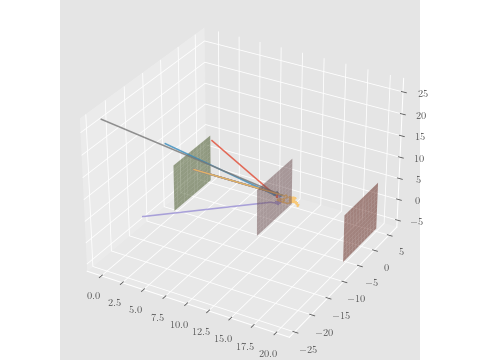

In [102]:
fig = plt.figure()
ax = Axes3D(fig)

co = np.zeros([5,3])
colours = ['red', 'blue', 'green', 'purple', 'k']

for i in range(5):
    coord, _, _, _ = woodcock_path(3, 0, 10, 10)
    ax.plot(coord[:, 0], coord[:,1], coord[:,2], alpha = 0.8)
    
Y, Z = np.meshgrid(np.arange(-6, 6), np.arange(-6, 6))
X_1 = 0*Y
X_2 = 10 + X_1
X_3 = 10 + X_2
    
#ax.plot(coord[:, 0], coord[:,1], coord[:,2], color='purple', alpha = 0.8)
ax.plot_surface(X_1, Y, Z, alpha=0.5)
ax.plot_surface(X_2, Y, Z, alpha=0.5)
ax.plot_surface(X_3, Y, Z, alpha=0.5)

One expects there to be all ficticious steps in the first material as it's air, so $\lambda= \infty$ giving $\Sigma_1 = 0$. So the probability of a ficticious step is 1. This is like when just a single material was examined in the previous section.

#### Lead and Water

Here the plot of 10cm of lead and 10cm of water is plotted for 5 different neutrons

<IPython.core.display.Javascript object>


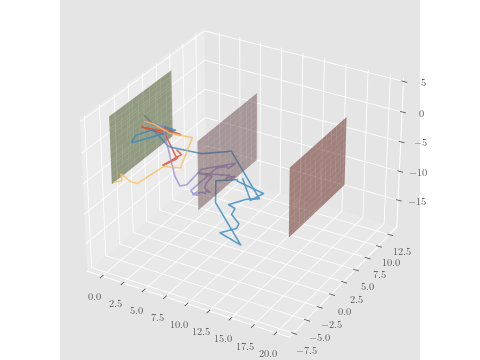

In [104]:
fig = plt.figure()
ax = Axes3D(fig)

co = np.zeros([5,3])
colours = ['red', 'blue', 'green', 'purple', 'k']

for i in range(5):
    coord, _, _, _ = woodcock_path(1, 0, 10, 10)
    ax.plot(coord[:, 0], coord[:,1], coord[:,2], alpha = 0.8)
    
Y, Z = np.meshgrid(np.arange(-6, 6), np.arange(-6, 6))
X_1 = 0*Y
X_2 = 10 + X_1
X_3 = 10 + X_2
    
#ax.plot(coord[:, 0], coord[:,1], coord[:,2], color='purple', alpha = 0.8)
ax.plot_surface(X_1, Y, Z, alpha=0.5)
ax.plot_surface(X_2, Y, Z, alpha=0.5)
ax.plot_surface(X_3, Y, Z, alpha=0.5)

One can see that with lead and water, not many neutrons make it to the water half of the ensemble. This is becuase the probability of a ficticious step is lower than before, and so it might be absorbed or reflected in the lead

#### Graphite and Water

Here the plot of 10cm of graphite and 10cm of water is plotted for 5 different neutrons

<IPython.core.display.Javascript object>


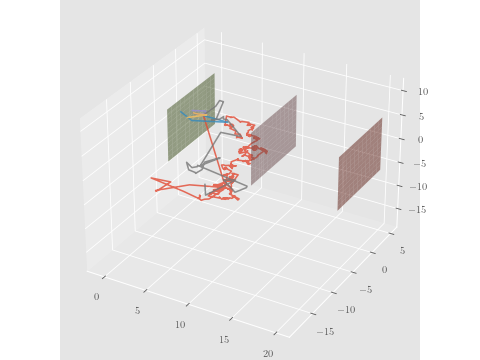

In [105]:
fig = plt.figure()
ax = Axes3D(fig)

co = np.zeros([5,3])

for i in range(5):
    coord, _, _, _ = woodcock_path(2, 0, 10, 10)
    ax.plot(coord[:, 0], coord[:,1], coord[:,2], alpha = 0.8)
    
Y, Z = np.meshgrid(np.arange(-6, 6), np.arange(-6, 6))
X_1 = 0*Y
X_2 = 10 + X_1
X_3 = 10 + X_2
    
#ax.plot(coord[:, 0], coord[:,1], coord[:,2], color='purple', alpha = 0.8)
ax.plot_surface(X_1, Y, Z, alpha=0.5)
ax.plot_surface(X_2, Y, Z, alpha=0.5)
ax.plot_surface(X_3, Y, Z, alpha=0.5)

#### Lead and Graphite

Here the plot of 10cm of lead and 10cm of graphite is plotted for 5 different neutrons.

<IPython.core.display.Javascript object>


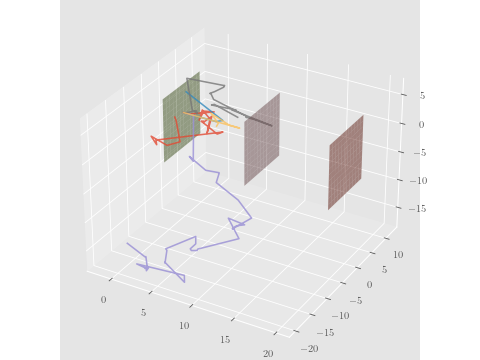

In [106]:
fig = plt.figure()
ax = Axes3D(fig)

co = np.zeros([5,3])
colours = ['red', 'blue', 'green', 'purple', 'k']

for i in range(5):
    coord, _, _, _ = woodcock_path(1, 2, 10, 10)
    ax.plot(coord[:, 0], coord[:,1], coord[:,2], alpha = 0.8)
    
Y, Z = np.meshgrid(np.arange(-6, 6), np.arange(-6, 6))
X_1 = 0*Y
X_2 = 10 + X_1
X_3 = 10 + X_2
    
#ax.plot(coord[:, 0], coord[:,1], coord[:,2], color='purple', alpha = 0.8)
ax.plot_surface(X_1, Y, Z, alpha=0.5)
ax.plot_surface(X_2, Y, Z, alpha=0.5)
ax.plot_surface(X_3, Y, Z, alpha=0.5)

### Test Woodcock function

One can see the function above works by testing it with air and water, getting the expected reflection absorption and transmission for each calculated above. This means that air needs to be added to the materials array. Air has $\lambda = \infty$ and so $\sigma = 0$. The result of this is that there will be only ficticious steps in air, until it reaches the water. Then if it's reflected it will just carry on in the reflected direction until it reaches the "end" of the air boundary.

The code below is very slow to run. This is because I could not figure out how to implement it with numpy arrays. In the appendix at the end is my attempt at it but it gives many errors, and I do not believe it is right.

<IPython.core.display.Javascript object>


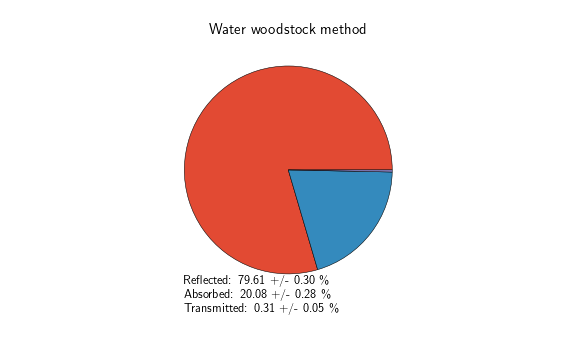

Text(-1, -1.5, 'Reflected: 79.61 +/- 0.30 \\%\nAbsorbed: 20.08 +/- 0.28 \\% \nTransmitted: 0.31 +/- 0.05 \\% \n')

In [108]:
neutrons = 10000
run_sim = 10

sims_a = np.zeros(run_sim)
sims_t = np.zeros(run_sim)
sims_r = np.zeros(run_sim)
for q in range(run_sim):
    
    total_a = 0
    total_t = 0
    total_r = 0
    
    for j in range(neutrons):
        _, absorbed, transmit, reflected = woodcock_path(3, 0, 10, 10)
        total_a += absorbed
        total_t += transmit
        total_r += reflected
    
    sims_a[q] = total_a
    sims_t[q] = total_t
    sims_r[q] = total_r
    
sims_a = (sims_a/neutrons)*100
sims_t = (sims_t/neutrons)*100
sims_r = (sims_r/neutrons)*100
    
a = np.mean(sims_a)
a_err = np.std(sims_a)
t = np.mean(sims_t)
t_err = np.std(sims_t)
r = np.mean(sims_r)
r_err = np.std(sims_r)

text_7 = """Reflected: {0:.2f} +/- {1:.2f} \%
Absorbed: {2:.2f} +/- {3:.2f} \% 
Transmitted: {4:.2f} +/- {5:.2f} \% \n""".format(r, r_err, a, a_err, t, t_err)

plt.figure(figsize=(10, 6)) #sets the figure size
plt.title('Water woodstock method')
plt.pie(w, wedgeprops = {'edgecolor' : 'k'})
plt.text(-1, -1.5, text_7, fontsize = 12)

One can confirm that the woodcock method works as these values are the ones expected and derivied early for neutrons through 10cm of water.

### Combination Rates

This code is seriously long to run, but gives the reflection, absorption and transmission for each combination of materials.

#### Lead and Water

<IPython.core.display.Javascript object>


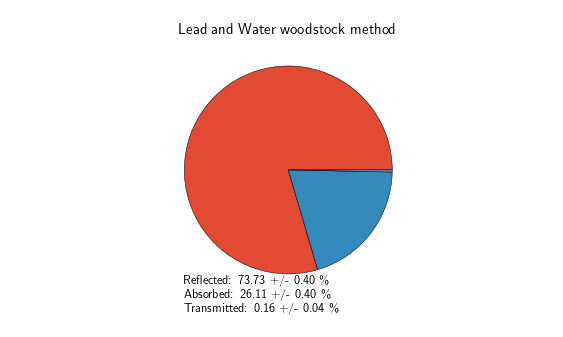

Text(-1, -1.5, 'Reflected: 73.73 +/- 0.40 \\%\nAbsorbed: 26.11 +/- 0.40 \\% \nTransmitted: 0.16 +/- 0.04 \\% \n')

In [109]:
neutrons = 10000
run_sim = 10

sims_a = np.zeros(run_sim)
sims_t = np.zeros(run_sim)
sims_r = np.zeros(run_sim)
for q in range(run_sim):
    
    total_a = 0
    total_t = 0
    total_r = 0
    
    for j in range(neutrons):
        _, absorbed, transmit, reflected = woodcock_path(1, 0, 10, 10)
        total_a += absorbed
        total_t += transmit
        total_r += reflected
    
    sims_a[q] = total_a
    sims_t[q] = total_t
    sims_r[q] = total_r
    
sims_a = (sims_a/neutrons)*100
sims_t = (sims_t/neutrons)*100
sims_r = (sims_r/neutrons)*100
    
a = np.mean(sims_a)
a_err = np.std(sims_a)
t = np.mean(sims_t)
t_err = np.std(sims_t)
r = np.mean(sims_r)
r_err = np.std(sims_r)

text_7 = """Reflected: {0:.2f} +/- {1:.2f} \%
Absorbed: {2:.2f} +/- {3:.2f} \% 
Transmitted: {4:.2f} +/- {5:.2f} \% \n""".format(r, r_err, a, a_err, t, t_err)

plt.figure(figsize=(10, 6)) #sets the figure size
plt.title('Lead and Water woodstock method')
plt.pie(w, wedgeprops = {'edgecolor' : 'k'})
plt.text(-1, -1.5, text_7, fontsize = 12)

#### Graphite and Water

<IPython.core.display.Javascript object>


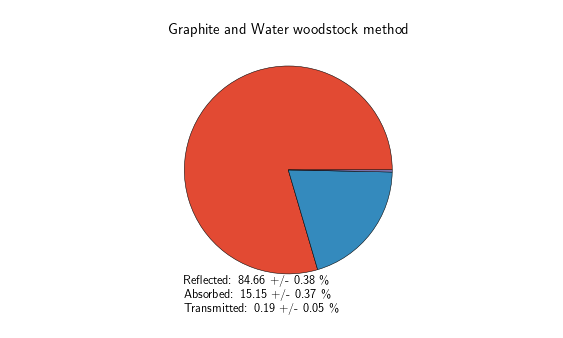

Text(-1, -1.5, 'Reflected: 84.66 +/- 0.38 \\%\nAbsorbed: 15.15 +/- 0.37 \\% \nTransmitted: 0.19 +/- 0.05 \\% \n')

In [110]:
neutrons = 10000
run_sim = 10

sims_a = np.zeros(run_sim)
sims_t = np.zeros(run_sim)
sims_r = np.zeros(run_sim)
for q in range(run_sim):
    
    total_a = 0
    total_t = 0
    total_r = 0
    
    for j in range(neutrons):
        _, absorbed, transmit, reflected = woodcock_path(2, 0, 10, 10)
        total_a += absorbed
        total_t += transmit
        total_r += reflected
    
    sims_a[q] = total_a
    sims_t[q] = total_t
    sims_r[q] = total_r
    
sims_a = (sims_a/neutrons)*100
sims_t = (sims_t/neutrons)*100
sims_r = (sims_r/neutrons)*100
    
a = np.mean(sims_a)
a_err = np.std(sims_a)
t = np.mean(sims_t)
t_err = np.std(sims_t)
r = np.mean(sims_r)
r_err = np.std(sims_r)

text_7 = """Reflected: {0:.2f} +/- {1:.2f} \%
Absorbed: {2:.2f} +/- {3:.2f} \% 
Transmitted: {4:.2f} +/- {5:.2f} \% \n""".format(r, r_err, a, a_err, t, t_err)

plt.figure(figsize=(10, 6)) #sets the figure size
plt.title('Graphite and Water woodstock method')
plt.pie(w, wedgeprops = {'edgecolor' : 'k'})
plt.text(-1, -1.5, text_7, fontsize = 12)

#### Lead and graphite

<ipython-input-111-bb4e5ca36a9e>:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 6)) #sets the figure size


<IPython.core.display.Javascript object>


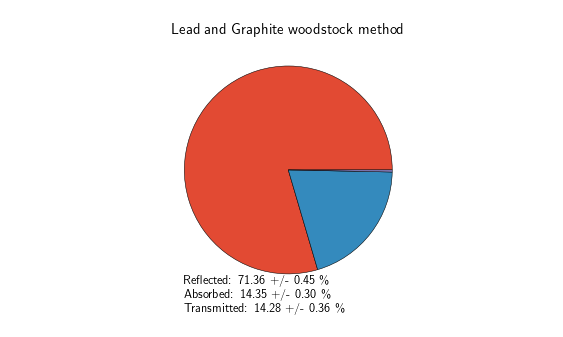

Text(-1, -1.5, 'Reflected: 71.36 +/- 0.45 \\%\nAbsorbed: 14.35 +/- 0.30 \\% \nTransmitted: 14.28 +/- 0.36 \\% \n')

In [111]:
neutrons = 10000
run_sim = 10

sims_a = np.zeros(run_sim)
sims_t = np.zeros(run_sim)
sims_r = np.zeros(run_sim)
for q in range(run_sim):
    
    total_a = 0
    total_t = 0
    total_r = 0
    
    for j in range(neutrons):
        _, absorbed, transmit, reflected = woodcock_path(1, 2, 10, 10)
        total_a += absorbed
        total_t += transmit
        total_r += reflected
    
    sims_a[q] = total_a
    sims_t[q] = total_t
    sims_r[q] = total_r
    
sims_a = (sims_a/neutrons)*100
sims_t = (sims_t/neutrons)*100
sims_r = (sims_r/neutrons)*100
    
a = np.mean(sims_a)
a_err = np.std(sims_a)
t = np.mean(sims_t)
t_err = np.std(sims_t)
r = np.mean(sims_r)
r_err = np.std(sims_r)

text_7 = """Reflected: {0:.2f} +/- {1:.2f} \%
Absorbed: {2:.2f} +/- {3:.2f} \% 
Transmitted: {4:.2f} +/- {5:.2f} \% \n""".format(r, r_err, a, a_err, t, t_err)

plt.figure(figsize=(10, 6)) #sets the figure size
plt.title('Lead and Graphite woodstock method')
plt.pie(w, wedgeprops = {'edgecolor' : 'k'})
plt.text(-1, -1.5, text_7, fontsize = 12)

## Summary

In this project, firstly pseudo random number distributions were investigated. It was seen that LCG's were not good random number generators as certain combinations of numbers meant there was a correlation between values. It was seen that the numpy function np.random.uniform() gave randomly distributed pseudo random numbers.

Exponentially distributed random numbers were then investigated using a nominal mean free path. A calculated mean free path could be calculated by running many simulations of the exponentially distributed numbers. If many simulations were run it was found that this calculated value converged to the nominal value.

Using this distribution the reflection, transmission and absorption rates of 3 materials were calculated. With material thickness of 10cm these values came out as roughly the following:
- Water:
 - Reflection ~80%
 - Absorption ~ 20%
 - Transmission ~ 0%

- Lead:
 - Reflection ~ 60%
 - Absorption ~ 10%
 - Transmission ~ 30%
 
- Graphite:
 - Reflection ~ 70%
 - Absorption ~ 0.5%
 - Transmission ~ 29.5%
 
The characteristic attenuation lengths for each material could also be calculated by varying the thickness of the material.

A sphere of each material was investigated to see which would be best at confining a source emitting neutrons. This was found to be water.

The woodcock method was then utilised to simulate two materials next to each other. It was confirmed to work by comparing a water and air combination to just the original water's reflection, transmission and absorption rates.

## Appendix A

Attempt at woodcock method using numpy arrays, my approach tried to separate those neutrons that were ficticious steps and those in the other material using masking. This breaks down though as where the comment is in the code it deletes roughly 139 entries when it shouldn't, and I can't see why this happens. Unfortunately this means that my code in the woodcock method even though correct is extremely slow and inefficient as I could not implement numpy arrays.

In [41]:
total_move = np.zeros([10000])
thickness_1 = 10
thickness_2 = 10
thickness = thickness_1 + thickness_2

sig_1 = 1/material[5, 0]
sig_2 = 1/material[5, 1]
material_ind_2 = 1
sig_T = np.amax([sig_1, sig_2])

reflection = 0
transmission = 0
absorption = 0

fict_rand_num = np.random.uniform(size=len(total_move))
#if fict_rand_number > (sig_1/sig_T):
fict_move_index = (fict_rand_num < (sig_1/sig_T))
fict_step = w_exponential((1/sig_T), len(fict_move_index)) * fict_move_index
total_fic = total_move * fict_move_index
total_fic += fict_step

material_1_neutrons = total_move < thickness_1
material_2_neutrons = total_move > thickness_1


#non fict steps
no_fict_move_index = (fict_rand_num > (sig_1/sig_T))
new_move, _, _ = w_iso_step((1/sig_T), len(no_fict_move_index)) * no_fict_move_index
total_non_fic = total_move * no_fict_move_index #creates step array for all non fict
total_non_fic += new_move #adds step to all non_ficts

u = np.random.uniform(size=len(total_non_fic))
reflection += len(np.argwhere(total_non_fic<0))
transmission += len(np.argwhere(total_non_fic > thickness))
absorption += len(np.argwhere((total_non_fic>0) & (total_non_fic<thickness) & (u < material[6, material_ind_2])))
total_non = np.delete(total_non_fic, np.argwhere((total_non_fic<0) | (total_non_fic > thickness) |
                                               (u < material[6, material_ind_2]) & (new_move == 0)))

#DELETES WHEN NOT MEANT TO

total_fic = np.delete(total_fic, np.argwhere((total_non_fic<0) | (total_non_fic > thickness) |
                                               (u < material[6, material_ind_2])))

total_move = total_non + total_fic


NameError: name 'w_exponential' is not defined